# App Development

The app was developed using the Holoviz Panel library, enabling an interactive user interface. Furthermore, it has been deployed with MyBinder, allowing for remote access from any location.

The app development process consisted of the following steps: 
- Designing the necessary functions 
- Constructing the Panel App
- Conducting rigorous testing of the app 
- Implementing any necessary fixes and adjustments

The app's logic was developed through a series of trial and error attempts, and could be summarised as follows: 
- Retrieving data from the database stored on Google Drive
- Normalising and clustering the selected features 
- Predicting the appropriate insulin dose for the input data within the relevant cluster
- Visualising the data within the cluster for further analysis.

It was crucial to separate the input data (the last row of the Google Sheet) and integrate it with the widgets, so that the visualizations and predictions could be modified interactively.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from pandas.plotting import parallel_coordinates
import panel as pn
from toggle_cell import toggle_code as hide

### Style configuration

In [2]:
#Colors
background = '#F0F0F0'
red = '#ED462F'
pink = '#F1BBB8'
green = '#4CB866'
blue = '#003D83'
black = '#333333'
grey = '#D0D9DC'
white = 'white'

#CSS 
css = '''
.bk-root {
    font-family: monospace
}
.bk-root .bk-tabs-header.bk-above .bk-headers-wrapper {
    border-bottom: none;
    background: #D0D9DC  
}
.bk-root .bk-tabs-header.bk-above .bk-tab {
    border-width: 2px 0px 0px 0px;
    border-radius: 0px;
    border-color: #D0D9DC
}
.bk-root .bk-tabs-header .bk-tab.bk-active {
    color: black;
    background-color: #F0F0F0;
}
.bk-root .bk-tabs-header .bk-headers-wrapper {
    color: black;
}
.bk-root .bk-tabs-header .bk-tab {
    padding: 15px 15px;
}
.bk-root .bk-tabs-header .bk-tab:hover {
    background-color: black;
    color: #F0F0F0
}
.bk-root .bk-input {
    border-radius: 0px;
    border: none;
    box-shadow:none;
    background:#F0F0F0
}
.bk-root .noUi-target {
    border-radius: 0px; 
    box-shadow:none;
    border: none;
    background: #F0F0F0
}
.bk-root .noUi-connects {
    border-radius: 0px;
}
.bk-root .noUi-handle {
    box-shadow: none;
    border: 3px solid;
    border-color: black;
    background: #F0F0F0;
}
.bk-root .noUi-horizontal .noUi-handle {
    width: 10px;
    height: 10px;
    right: -5px;
    top: 0px;
    border-radius: 5px;
}
.bk-root .noUi-horizontal .noUi-tooltip {
    bottom: -38px;
}
.bk-root .noUi-tooltip {
    border: none;
    border-radius: 0px;
    background: black;
    color: white;
}
.tabulator {
    border-radius: 0px !important;
    background-color: #F0F0F0 !important
}

.tabulator .tabulator-header, .tabulator .tabulator-header .tabulator-col {
    background-color: #D0D9DC !important
}
.tabulator-row.tabulator-group {
    background: #D0D9DC !important
}
.tabulator-row {
    background-color: transparent !important
}
.bk-root .bk-btn {
    border-radius: 0px
}
.bk-root .bk-btn-primary {
    background-color: black;
    border-color: black;
}
.bk-root .bk-btn-primary:hover {
    background-color: black;
    border-color: black;
}
.bk-root .bk-btn-primary.bk-active {
    background-color: #F0F0F0;
    border-color: #F0F0F0;
    color:black
}
.bk-root .bk-btn.bk-active {
    box-shadow: none;
}
'''

#Matplotlib configurations
plt.rcParams['axes.facecolor'] = grey
plt.rcParams['figure.facecolor'] = background
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['xtick.color'] = background
plt.rcParams['ytick.color'] = background
plt.rcParams['xtick.labelcolor'] = '#8C9496'
plt.rcParams['ytick.labelcolor'] = '#8C9496'
plt.rcParams['legend.labelcolor'] = '#8C9496'
plt.rcParams['grid.color'] = background
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.axisbelow'] = True

#Panel configuration
pn.extension('tabulator',raw_css=[css])
pn.widgets.Tabulator.theme = 'semantic-ui'

#Hide function
hide()

### Read data

In [3]:
#Read data from Google Drive
url='https://docs.google.com/spreadsheets/d/1fIIkTPAtJvKFh3cbZmOBgsqKATPn2kHlWj1kXzMvv2M/edit?usp=sharing'
path = 'https://docs.google.com/spreadsheets/d/'+url.split('/')[-2]+'/export?gid=0&format=csv'
df = pd.read_csv(path,usecols=['Date','Interval','bID','BG1','BG2','DV','SC','Sport','Temp','Humid','shID','Y-shID'])
#Dropping empty rows at the end of the spreadsheet
rows_to_drop = df.index[df['BG1'].isna()].tolist()
df.drop(rows_to_drop,inplace=True)
#The last Y-shID cell reads as a string as it contains a formula
#Replacing the string value with None and converting the column values into floats
df.iloc[-1,-1] = None
df['Y-shID'] = df['Y-shID'].astype(float)
df

,Date,Interval,bID,BG1,BG2,DV,SC,Sport,Temp,Humid,shID,Y-shID
0,12/9/2022,breakfast-lunch,3.0,4.7,4.7,1.756,3501.0,False,-17.0,81.0,3.5,3.50
1,12/9/2022,lunch-dinner,2.5,4.7,4.3,2.511,3098.0,False,-10.0,71.0,2.0,1.83
2,12/9/2022,dinner-breakfast,2.0,4.3,6.5,3.442,0.0,False,-14.0,83.0,4.0,5.53
3,12/10/2022,breakfast-lunch,3.0,6.5,5.6,1.584,2734.0,False,-15.0,88.0,4.0,4.77
4,12/10/2022,lunch-dinner,2.5,5.6,6.2,2.562,2410.0,False,-12.0,77.0,2.0,2.64
...,...,...,...,...,...,...,...,...,...,...,...,...
235,2/25/2023,lunch-dinner,3.0,6.7,5.4,1.952,0.0,False,-10.0,64.0,3.0,3.45
236,2/25/2023,dinner-breakfast,3.0,3.8,4.1,2.677,0.0,False,-9.0,74.0,2.5,2.18
237,2/26/2023,breakfast-lunch,3.0,4.3,4.3,1.753,3090.0,False,-18.0,82.0,3.5,3.20
238,2/26/2023,lunch-dinner,3.0,3.9,4.7,2.153,3270.0,False,-8.0,56.0,2.5,2.50


## 1. Designing functions

### Prepare data for clustering

In [4]:
#Takes in a df with selected features > returns a normalised df
def prepare_clustering(work_df):
    
    #Convert to dummy variables
    df_wd = pd.get_dummies(work_df)
    
    #Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_wd)
    scaled_df = pd.DataFrame(scaled_data,columns=df_wd.columns)
    
    return scaled_df   

In [5]:
#Takes in a scaled df > returns a data set X ready for clustering
def create_scaled_X(scaled_df):
    scaled_X = scaled_df.drop('Y-shID',axis=1)
    return scaled_X

### Cluster data

In [6]:
#Takes in X features > returns a list of cluster indices where the input data belongs
def get_cluster_indices(scaled_X):
    model = AgglomerativeClustering(n_clusters=None,linkage='ward',distance_threshold=0.6)
    cluster_labels = model.fit_predict(scaled_X)
    cluster_indices = [i for i, x in enumerate(cluster_labels) if x == cluster_labels[-1]]
    return cluster_indices

### Prepare data for regression

In [7]:
#Takes in a scaled df and a list of cluster indices > returns scaled X features
def create_scaled_X_cluster(scaled_df,cluster_indices):
    scaled_X_cluster = scaled_df.iloc[cluster_indices[:-1],[1,2,3,5,6]]
    return scaled_X_cluster 

In [8]:
#Takes in a scaled df and a list of cluster indices > returns scaled y labels
def create_scaled_y_cluster(scaled_df,cluster_indices):
    scaled_y_cluster = scaled_df.iloc[cluster_indices[:-1],[7]]
    return scaled_y_cluster 

In [9]:
#Takes in a scaled df and a list of cluster indices > returns scaled X input features
def create_scaled_X_pred(scaled_df,cluster_indices):
    scaled_X_pred = scaled_df.iloc[[cluster_indices[-1]],[1,2,3,5,6]]
    return scaled_X_pred

### Scaled prediction

In [10]:
#Takes in scaled X features, y labels and X input features > returns scaled Y-shID prediction
def predict_scaled_y(scaled_X_cluster, scaled_y_cluster, scaled_X_pred):
    model = LinearRegression()
    model.fit(scaled_X_cluster,scaled_y_cluster)
    scaled_y_pred = model.predict(scaled_X_pred) 
    return scaled_y_pred

### Inversed prediction

In [11]:
#Takes in scaled y prediction and the df that has been originally scaled > returns inversed Y-shID prediction
def inverse_scaled_y(scaled_y_pred,work_df):
    y_pred = (work_df['Y-shID'].max()-work_df['Y-shID'].min())*scaled_y_pred[0] + work_df['Y-shID'].min()
    return y_pred

### Calculated prediction

In [12]:
#Takes in the work df > returns calculated Y-shID
def calculate_y(work_df):
    y_calc = (work_df.iloc[-1,2]-4.7)/2.8 + work_df.iloc[-1,3]/1 #data from the last row of the df
    return y_calc

### Create cluster dfs

In [13]:
#Takes in scaled elements of the cluster > returns scaled cluster df
def create_scaled_cluster_df(scaled_X_cluster,scaled_y_cluster,scaled_X_pred,scaled_y_pred):
    scaled_cluster_df = pd.concat([scaled_X_cluster,scaled_X_pred])
    scaled_cluster_df['Y-shID'] = scaled_y_cluster
    scaled_cluster_df.iloc[-1,-1] = scaled_y_pred[0]
    return scaled_cluster_df

In [14]:
#Takes in a list of cluster indices, y prediction and the work df  > returns cluster df
def create_cluster_df(cluster_indices,y_pred,work_df):
    cluster_df = work_df.iloc[cluster_indices,[2,3,4,6,7,8]] #selecting rows corresponding to the cluster
    cluster_df.iloc[-1,-1] = y_pred #replacing the Y-shID value with the predicted value
    return cluster_df

### Plotting functions

In [15]:
#Takes in scaled and normal cluster dfs, y prediction and the calculated y
#Returns parallel coordinates plot where cluster data and input data are visualised 
#Also displays the predicted and the calculated Y-shID values side by side for comparison
def parallel_plot(scaled_cluster_df,cluster_df,y_pred,y_calc):
    
    #get column names
    cols = cluster_df.columns
    
    #create figure
    fig = plt.figure(figsize=(13,6.75))
    plt.xlim(0,5)
    plt.ylim(-0.2,1.2)
    plt.grid(linewidth=2)

    #xticks as column names
    xticks = plt.gca().get_xticks()      
    plt.xticks(xticks,cols)

    #yticks on the first axis
    yticks = plt.gca().get_yticks()
    start = df[cols[0]].min()
    end = df[cols[0]].max()
    ylabels = [''] + list(np.round(np.linspace(start,end,6,endpoint=True),2)) + ['']
    plt.gca().set_yticks(yticks,[])
    plt.gca().set_yticklabels(ylabels,va='bottom')

    #Twin Y axes and yticklabels
    for i in range(1,len(cols)):
        ax = plt.twinx()
        ax.spines["left"].set_position(("axes", i/(len(cols)-1)))  
        ax.set_ylim(-0.2,1.2)
        yticks = ax.get_yticks()
        ax.set_yticks(yticks,[])
        start = df[cols[i]].min()
        end = df[cols[i]].max()
        ylabels = [''] + list(np.round(np.linspace(start,end,6,endpoint=True),2)) + ['']
        ax.set_yticklabels(ylabels,va='bottom')

    #Align ylabels on the last axis to the left
    plt.gca().yaxis.set_label_position('left')
    plt.gca().yaxis.set_ticks_position('left')

    #Plot lines
    x = range(len(cols))
    #Plot cluster lines
    for i in range(len(scaled_cluster_df[:-1])):    
        y = scaled_cluster_df.iloc[i]
        plt.plot(x,y,color=pink,linewidth=1)
    #Plot input line   
    y = scaled_cluster_df.iloc[-1]
    plt.plot(x,y,color=red,linewidth=3)

    #Annotate input line
    xlist=plt.gca().lines[-1].get_data()[0]
    ylist=plt.gca().lines[-1].get_data()[1]
    for x,y in zip(xlist,ylist):
        plt.text(x+0.03,y+0.03,'%.2f' % cluster_df.iloc[-1,x],fontweight='bold',fontsize=14)
    
    #Highlight predicted and calculated insulin dose
    plt.text(3.75,-0.45,f'Predicted ID: {round(y_pred[0],2)}',color='white',bbox=dict(facecolor=blue, edgecolor='none', pad=10),
                 ha='right',fontsize=14,fontweight='bold')
    plt.text(4.95,-0.45,f'Calculated ID*: {round(y_calc,2)}',color='white',bbox=dict(facecolor=green, edgecolor='none', pad=10),
                 ha='right',fontsize=14,fontweight='bold')
    plt.text(5,-0.55,'*Variables used for calculation: correction factor: 2,8 mmol/l, insulin to carb ratio: 1:1',ha='right',color='#8C9496')
        
        
    #Close figure   
    plt.tight_layout()
    plt.close(fig)
        
    return fig

In [16]:
#Takes in normal cluster data
#Returns several scatter plots where predicted Y-shID visualised vs other features
def scatter_plot(cluster_df):
    cols = cluster_df.columns
    fig,axes = plt.subplots(nrows=1,ncols=5,figsize=(15,7))
    axes[0].set_ylabel('Y-shID') 
    for i,col in enumerate(cols[:-1]): 
        axes[i].axhline(y=cluster_df.iloc[-1,-1], color=blue, linestyle='-',linewidth=1) 
        axes[i].axvline(x=cluster_df.iloc[-1,i], color=blue, linestyle='-',linewidth=1)
        axes[i].scatter(cluster_df.iloc[:-1,i],cluster_df.iloc[:-1,-1],color=pink,s=80)
        axes[i].scatter(cluster_df.iloc[-1,i],cluster_df.iloc[-1,-1],color=red,s=120,zorder=2.5)
        axes[i].set_xlabel(col)    
        axes[i].grid(linewidth=2)
        axes[i].text(cluster_df.iloc[-1,i],cluster_df.iloc[-1,-1]+0.1,
                     f'{round(cluster_df.iloc[-1,i],2)}',ha='center',
                     fontweight='bold',fontsize=16)

    plt.tight_layout()
    plt.close(fig)
        
    return fig

In [17]:
#Takes in cluster indices and predicted Y-shID value
#Returns a spreadsheet view using Tabulator widget
def tables(cluster_indices,y_pred): 
    table_df1 = df.iloc[cluster_indices[:-1],[0,3,4,5,6,8,9,10,11]]
    table1 = pn.widgets.Tabulator(table_df1,selectable=False,show_index=False,disabled=True,
                                  sizing_mode='scale_both',layout='fit_columns',text_align='left',height=250)
    table_df2 = df.iloc[[-1],[0,3,4,5,6,8,9,10,11]]
    table_df2.iloc[-1,-1] = y_pred[0]
    table2 = pn.widgets.Tabulator(table_df2,selectable=False,show_index=False,disabled=True,
                                  sizing_mode='scale_both',layout='fit_columns',text_align='left',height=100)
    tables = pn.Column(pn.pane.Markdown('###/ / / Cluster data'),
                       table1,
                       pn.Spacer(height=10),
                       pn.pane.Markdown('###/ / / Input data'),
                       table2,
                       margin=(30,30,0,30),sizing_mode='scale_both')
    return tables

## 2. Constructing the Panel app

### Defining widgets

In [18]:
#Input widgets taking in the last row from the imported Google spreadsheet as their value
Interval = pn.widgets.Select(name='Interval', options=['breakfast-lunch', 'lunch-dinner', 'dinner-breakfast'],
                             value=df.iloc[-1,1],margin=(5,0))
bID = pn.widgets.FloatSlider(name='Basal insulin delivery', start=0, end=10, step=0.5, 
                           value=df.iloc[-1,2],bar_color = black,margin=(5,0)) 
BG1 = pn.widgets.FloatSlider(name='Pre-meal blood glucose in mmol/l', start=0, end=15, step=0.1, 
                             value=df.iloc[-1,3],bar_color = black,margin=(5,0))
DV = pn.widgets.FloatSlider(name='Dietary value in grams/10', start=0, end=10, step=0.001, 
                            value=df.iloc[-1,5],bar_color = black,margin=(5,0))
SC = pn.widgets.FloatSlider(name='Step count in steps', start=0, end=20000, step=100, 
                                 value=df.iloc[-1,6],bar_color = black,margin=(5,0)) 
Sport = pn.widgets.Checkbox(name=' Sport',value=bool(df.iloc[-1,7]),margin=(5,0))
Temp = pn.widgets.FloatSlider(name='Temperature in °C', start=-40, end=40, step=1, 
                            value=df.iloc[-1,8],bar_color = black,margin=(5,0)) 
Humid = pn.widgets.FloatSlider(name='Humidity in %', start=0, end=100, step=1, 
                             value=df.iloc[-1,9],bar_color = black,margin=(5,0))


### Creating a plotting function

In [19]:
#Takes in widgets values > returns interactive plots as a 'tabs' element
def plot_cluster(Interval,bID,BG1,DV,SC,Sport,Temp,Humid): 
    
    #Separate input data into a widget dependent df 
    work_df = df[['Interval','bID','BG1','DV','SC','Sport','Temp','Humid','Y-shID']]
    input_df = pd.DataFrame({'Interval': Interval, 'bID': bID, 'BG1': BG1, 'DV': DV, 'SC': SC,
                           'Sport': Sport, 'Temp': Temp, 'Humid': Humid}, index=[0])
    work_df = pd.concat([work_df[:-1],input_df])
    work_df.reset_index(drop=True,inplace=True)
    
    #Cluster
        #Prepare for clustering
    scaled_df = prepare_clustering(work_df) #scales data
    scaled_X = create_scaled_X(scaled_df) #drops Y-shID
        #Clustering
    cluster_indices = get_cluster_indices(scaled_X) #clusters and returns cluster indices
    
    #Check if cluster is empty before performing prediction
    if len(cluster_indices) == 1:
        tabs = pn.pane.Markdown('#_No matching cluster found!',sizing_mode='scale_both',margin=(30,30))
    
    else:
        #Predict insulin
            #Prepare for prediction
        scaled_X_cluster = create_scaled_X_cluster(scaled_df,cluster_indices) #creates scaled X for the cluster
        scaled_y_cluster = create_scaled_y_cluster(scaled_df,cluster_indices) #creates scaled y for the cluster
        scaled_X_pred = create_scaled_X_pred(scaled_df,cluster_indices) #scaled X_pred (input data)
            #Predict
        scaled_y_pred = predict_scaled_y(scaled_X_cluster,scaled_y_cluster,scaled_X_pred) #returns scaled y label
        y_pred = inverse_scaled_y(scaled_y_pred,work_df) #returns inversed y_pred 

        #Calculate insulin
        y_calc = calculate_y(work_df)

        #Plot data
            #Prepare for plotting
        scaled_cluster_df = create_scaled_cluster_df(scaled_X_cluster,scaled_y_cluster,scaled_X_pred,scaled_y_pred)
        cluster_df = create_cluster_df(cluster_indices,y_pred,work_df)
            
            #Tab1 - parallel plot
        tab1 = parallel_plot(scaled_cluster_df,cluster_df,y_pred,y_calc)
             
            #Tab2 - table view
        tab2 = tables(cluster_indices,y_pred)
        
            #Tab3 - scatter plot
        tab3 = scatter_plot(cluster_df)
       
        #Organise in tabs
        tabs = pn.Tabs(('Parallel coordinates plot',pn.Column(pn.pane.Markdown('###/ / / Cluster data vs input data'),
                                          pn.pane.Matplotlib(tab1,sizing_mode='scale_both'),
                                          margin=(30,30,0,30),sizing_mode='scale_both')),
                       ('Spread sheet', tab2),
                       ('Scatter plots',pn.Column(pn.pane.Markdown('###/ / / Cluster vs input'),
                                            pn.pane.Matplotlib(tab3,sizing_mode='scale_both'),
                                            margin=(30,30,0,30),sizing_mode='scale_both')),
                         sizing_mode='scale_both',background=background)
    
    
    return tabs

### Binding the widgets and the function

In [20]:
#Binding widgets and function
layout = pn.interact(plot_cluster,Interval=Interval,bID=bID,BG1=BG1,DV=DV,SC=SC,Sport=Sport,
                      Temp=Temp,Humid=Humid)

### Constructing the app layout

Row(background='#333333')
    [0] Column(margin=(0, 15), sizing_mode='scale_height')
        [0] Spacer(height=183)
        [1] Markdown(str, margin=(2, 0))
        [2] Markdown(str, margin=(2, 0))
        [3] Markdown(str, margin=(2, 0))
        [4] Markdown(str, margin=(2, 0))
    [1] Column(background='#D0D9DC', sizing_mode='scale_both')
        [0] Markdown(str, margin=(15, 15, 0, 15), sizing_mode='scale_width')
        [1] Row
            [0] Column(margin=(0, 15))
                [0] Markdown(str, margin=(5, 0))
                [1] Column
                    [0] Select(margin=(5, 0), name='Interval', options=['breakfast-lunch', ...], value='dinner-breakfast')
                    [1] FloatSlider(bar_color='#333333', end=10, margin=(5, 0), name='Basal insulin delivery', step=0.5, value=3.0)
                    [2] FloatSlider(bar_color='#333333', end=15, margin=(5, 0), name='Pre-meal blood g..., value=4.7)
                    [3] FloatSlider(bar_color='#333333', end=10, margin=(5, 0), name='Dietary value i..., step=0.001, value=2.643)
                    [4] FloatSlider(bar_color='#333333', end=20000, margin=(5, 0), name='Step count in steps', step=100)
                    [5] Checkbox(margin=(5, 0), name=' Sport')
                    [6] FloatSlider(bar_color='#333333', end=40, margin=(5, 0), name='Temperature in °C', start=-40, step=1, value=-9.0)
                    [7] FloatSlider(bar_color='#333333', end=100, margin=(5, 0), name='Humidity in %', step=1, value=65.0)
                [2] Spacer(height=65)
                [3] Markdown(str, margin=(5, 0))
            [1] Row(sizing_mode='scale_both')
                [0] Tabs(background='#F0F0F0', sizing_mode='scale_both')
                    [0] Column(margin=(30, 30, 0, 30), sizing_mode='scale_both')
                        [0] Markdown(str)
                        [1] Matplotlib(Figure, height=486, sizing_mode='scale_both', width=936)
                    [1] Column(margin=(30, 30, 0, 30), sizing_mode='scale_both')
                        [0] Markdown(str)
                        [1] Tabulator(disabled=True, height=250, layout='fit_columns', selectable=False, show_index=False, sizing_mode='scale_both', text_align='left', value=          Date  ...)
                        [2] Spacer(height=10)
                        [3] Markdown(str)
                        [4] Tabulator(disabled=True, height=100, layout='fit_columns', selectable=False, show_index=False, sizing_mode='scale_both', text_align='left', value=          Date  ...)
                    [2] Column(margin=(30, 30, 0, 30), sizing_mode='scale_both')
                        [0] Markdown(str)
                        [1] Matplotlib(Figure, height=504, sizing_mode='scale_both', width=1080)
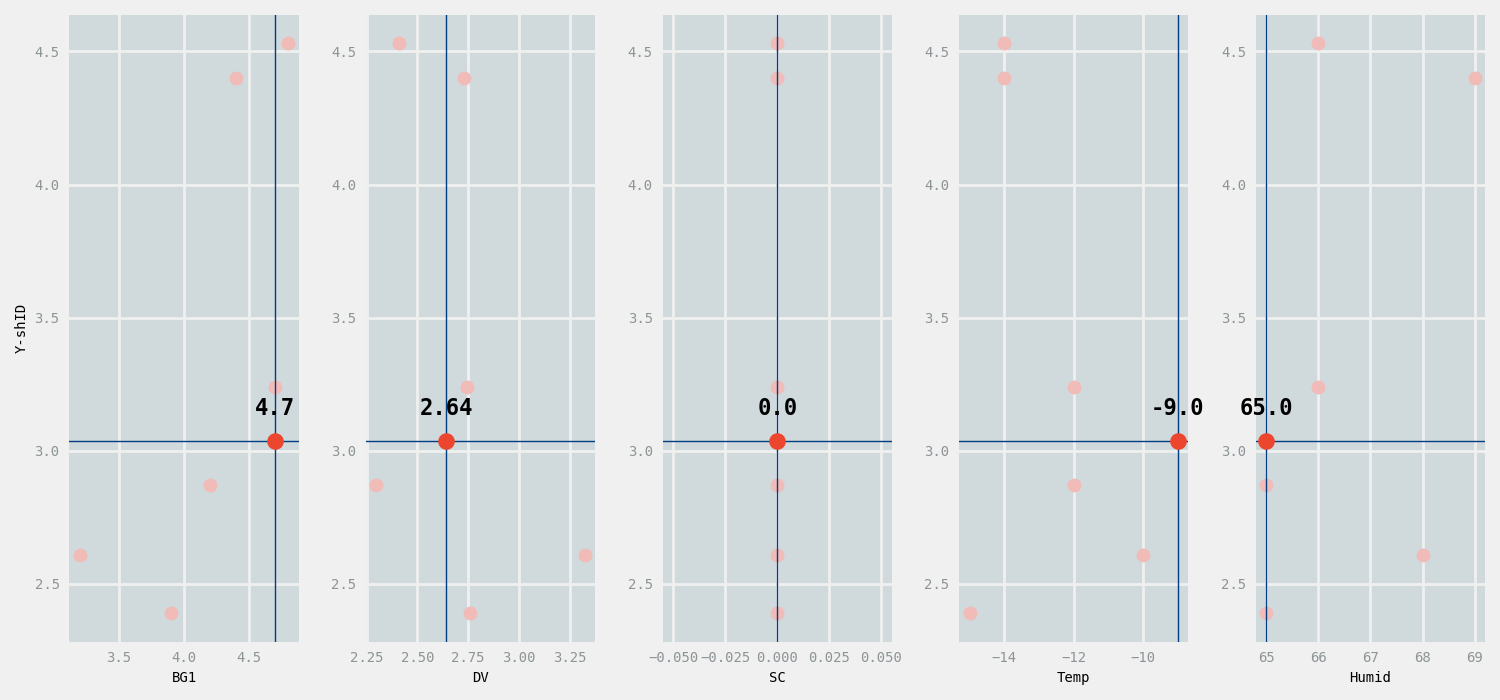
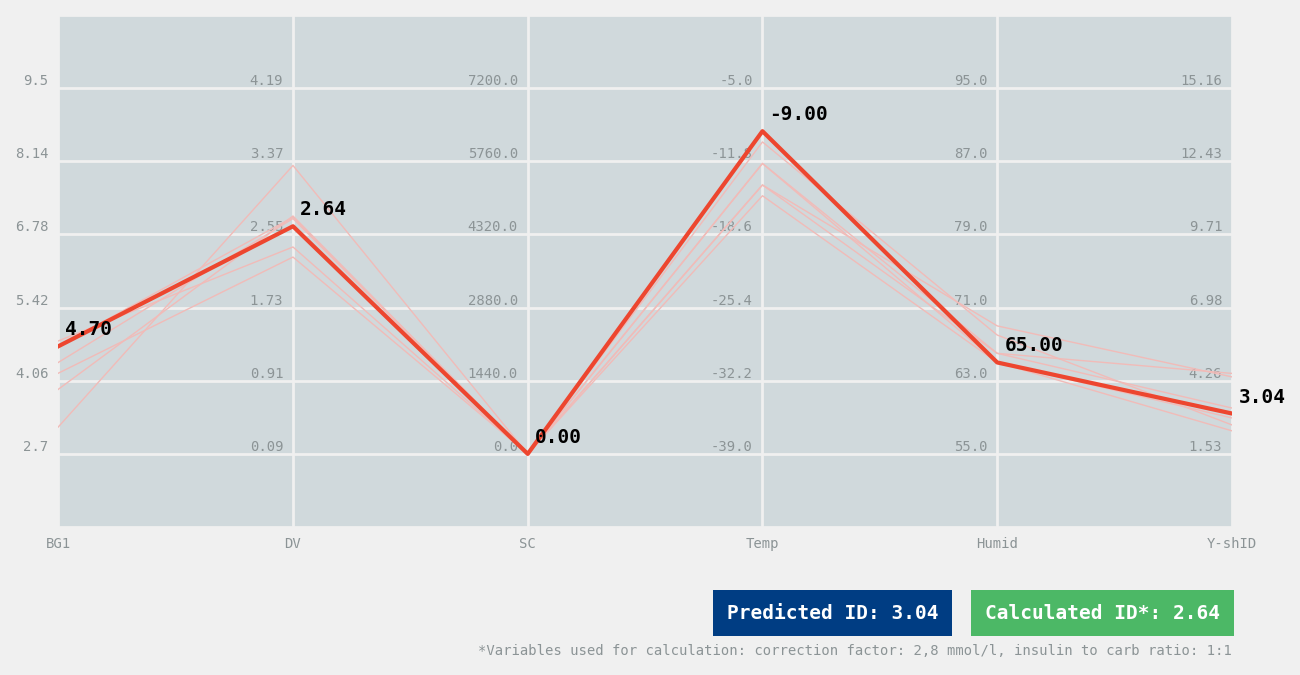

In [21]:
#Panel
c1 = pn.Column(pn.pane.Markdown('###_Input data',margin=(5,0)),
               layout[0],
               pn.Spacer(height=65),
               pn.pane.Markdown('shID - actual short insulin delivery\n\nYshID - recommended short insulin delivery',margin=(5,0)),
               margin=(0,15))
c2 = pn.Column(pn.Spacer(height=183),
               pn.pane.Markdown(f'<span style="color: white;">bID</span>',margin=(2,0)),
               pn.pane.Markdown(f'<span style="color: white;">BG1</span>',margin=(2,0)),
               pn.pane.Markdown('<span style="color: white;">DV</span>',margin=(2,0)),
               pn.pane.Markdown('<span style="color: white;">SC</span>',margin=(2,0)),
               sizing_mode='scale_height',margin=(0,15))
r1 = pn.Row(c1,layout[1])
c3 = pn.Column(pn.pane.Markdown('##:: diabetes_app',margin=(15, 15, 0, 15),sizing_mode='scale_width'),
               r1,sizing_mode='scale_both',background=grey)

panel = pn.Row(c2,c3,background=black)
panel.servable()

In [22]:
#Saving as a HTML file for a full screen preview
from bokeh.resources import INLINE
panel.save('DiabetesApp.html', resources=INLINE)